In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Clearing the current figure
plt.clf()

<Figure size 640x480 with 0 Axes>

In [5]:
# -------- functionality
shw = 1
do_prt = 0  # Python plotting: only makes sense when shw > 0
bvout = 1
bbnet = 1

In [6]:
# -------- sizes
cfs = 6  # coefficients per patch (total degree quadratic)
idx1 = np.arange(1, cfs + 1)  # orientation
idx0 = [3, 2, 1, 5, 4, 6]
pats = 6  # patches per triangle
n = 32  # evaluation density
dim = 3  # dimension of range (3-space)
tet = 0  # use tetrahedra data

In [20]:
# --------- evaluated BB basis functions
u0 = np.linspace(0, 1, n)
u, v = np.meshgrid(u0, u0)
bbb = {1: (1 - u - v) ** 2, 2: 2 * (1 - u - v) * u, 3: u * u, 4: 2 * (1 - u - v) * v, 5: 2 * v * u, 6: v * v}
mask = np.ones((n, n))  # suppress half of the 4-sided patch
bidx = np.triu_indices(n, k=1)
mask[bidx] = np.nan

In [8]:
# Valences
nn = np.array([3, 4])
c0 = np.cos(2 * np.pi / nn)

# Rational weights
wni = 3 * (1 - c0) / (c0 + 1)
wti = 3 / (2 * (c0 + 1))

In [9]:
# -------- GEOMETRY+CONNECTIVITY:  double simplex
# Vertices
V = np.array([
    np.cos(2 * np.pi * np.array([0, 1, 2]) / 3).tolist() + [0, 0],
    np.sin(2 * np.pi * np.array([0, 1, 2]) / 3).tolist() + [0, 0],
    [0, 0, 0, -1, 1]
])
val = np.array([4, 4, 4, 3, 3])

In [10]:
# Neighbors
nbr = np.array([
    [1, 4, 3, 5, 4, 1],
    [2, 2, 2, 2, 3, 3],
    [4, 3, 5, 1, 1, 5]
]).T

if tet == 1:
    # -------- tet
    V = 3 * np.array([
        [-1, 1, 1, -1],
        [-1, 1, -1, 1],
        [-1, -1, 1, 1]
    ])
    val = np.array([3, 3, 3, 3])
    nbr = np.array([
        [2, 3, 4],
        [1, 4, 3],
        [4, 1, 2],
        [3, 2, 1]
    ])

nbl = nbr[:, [2, 1, 0]]  # Reorder columns of nbr
dim, vts = V.shape  # Get dimensions of V
fcs, vfc = nbr.shape  # Get dimensions of nbr

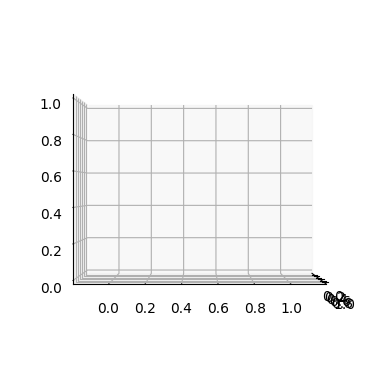

In [11]:
# ---- draw funnel
if shw > 0:
    clr = ['y', 'c', 'r']  # Colors
    fidx = [1, 2, 5]  # Indices for funnel drawing

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for jj in range(3):
        ii = fidx[jj] - 1  # 0-based indexing

    ax.view_init(elev=-V[0, -1], azim=V[1, -1])  # 0-based indexing
    ax.axis('equal')
    plt.show()

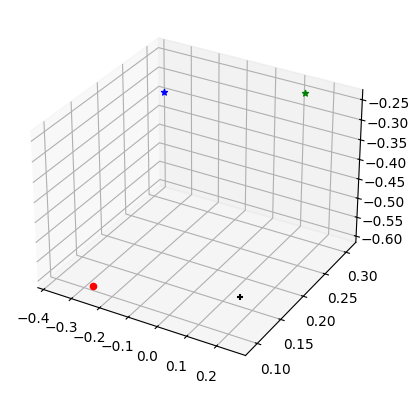

IndexError: index 5 is out of bounds for axis 0 with size 5

In [23]:
# --- complete Euclidean part of a single quadratic
if bvout == 1:
    fp = open('mixW.bv', 'w')
for orient in range(1, 3):
    if orient == 1:
        nbs = nbr
        idx = idx1
        if bvout == 1:
            print("group {} odd".format(orient), file=fp)
    else:
        nbs = nbl
        idx = idx0
        if bvout == 1:
            print("group {} even".format(orient), file=fp)

    fc = [None] * fcs
    ctr = np.zeros((V.shape[0], fcs))
    dual = [None] * fcs
    for ff in range(fcs):
        fc[ff] = V[:, nbs[ff, :] - 1]
        # ctr[:, ff] = np.dot(fc[ff], np.ones((vfc, 1))) / vfc
        ctr[:, ff] = np.mean(fc[ff], axis=0)
        dual[ff] = np.zeros((V.shape[0], vfc))
        for kk in range(vfc):
            dual[ff][:, kk] = (3 * ctr[:, ff] + fc[ff][:, kk]) / 4

    # --- project vtx neighbors MISSING(not needed for specific geometry)
    for ii in range(vts):
        # project duals -- currently left out since valence 3 or 4
        pass

    for ff in range(fcs):
        for kk in range(vfc):  # k = index inside face if rem(pat,2)==1
            pat = 2 * kk + orient
            km = kk - 1
            if km < 0:
                km = kk + vfc - 1
            kp = kk + 1
            if kp >= vfc:
                kp = kk - vfc + 1
            top = nbs[ff, kk]  # top global vertex index
            nxt = nbs[ff, kp]  # bottom left vertex index
            prv = nbs[ff, km]  # bottom right vertex index
            # kk
            # kp km
            # nxt prv
            ntp = 0
            for tt in range(fcs):  # neighbor triangle nxt
                for ii in range(vfc):
                    ip = ii + 1
                    if ip >= vfc:
                        ip = 1
                    if nbs[tt, ii] == nxt and nbs[tt, ip] == top:
                        ntp = tt
                        break
                if ntp != 0:
                    break

            ntm = 0
            for jj in range(fcs):  # neighbor triangle prv-top edge
                for nn in range(vfc):
                    np1 = nn + 1
                    if np1 >= vfc:
                        np1 = 1
                    if nbs[jj, nn] == top and nbs[jj, np1] == prv:
                        ntm = jj
                        break
                if ntm != 0:
                    break

            # v10 v00 ff
            # v11 v01
            vf0 = dual[ff][:, kk]
            vfp = dual[ff][:, kp]
            vfm = dual[ff][:, km]
            v0p = dual[ntp][:, ip]
            v1p = dual[ntp][:, ii]
            v0m = dual[ntm][:, nn]
            if pat == 1 and ff == 1:
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(vf0[0], vf0[1], vf0[2], color='r', marker='o')
                ax.scatter(v0p[0], v0p[1], v0p[2], color='g', marker='*')
                ax.scatter(vfp[0], vfp[1], vfp[2], color='b', marker='*')
                ax.scatter(v1p[0], v1p[1], v1p[2], color='k', marker='+')
                plt.show()

            wti_top = wti[val[top] - 3]
            wti_bot = wti[val[nxt] - 3]
            wni_top = wni[val[top] - 3]
            # w_top = 2 * (1 + c0(val(top) - 2)) / 3
            # w_bot = 2 * (1 + c0(val(nxt) - 2)) / 3
            # w_prv = 2 * (1 + c0(val(prv) - 2)) / 3
            w_top = 1
            w_bot = 1
            w_prv = 1
            w1 = np.sqrt(wti_top * wti_bot)
            w5 = w_top
            w4 = w_top * wti_top
            wgt = [w1, w5, (w_top + w_bot + w_prv) / 3, w4, w5, w_top * wni_top]

            qE = np.zeros((3, 6)) # Initialize qE as a 3x6 zero matrix: 3 rows for 3D points, 6 columns for the weights
            # --- assemble by averaging in coeff_i weight_i
            qE[:, 4] = wgt[4] * vf0
            qE[:, 1] = wgt[1] * (vf0 + vfp) / 2
            midopp = wgt[1] * (v0p + v1p) / 2
            qE[:, 3] = wgt[3] * (vf0 + v0p) / 2
            qE[:, 0] = wgt[0] * (vf0 + vfp + v0p + v1p) / 4
            qE[:, 2] = (w_top * vf0 + w_bot * vfp + w_prv * vfm) / 3

            # top is average:  v0p-o + v0m-o = (vf0-o)*2c0
            #  v0p+v0m-vf0(2c0) = 2o-2c0o = 2(1-c0)o
            cc = c0[val[top] - 3]
            tv = (v0p + v0m - 2 * cc * vf0) / (2 * (1 - cc))  # top vertex Euclidian
            qE[:, 5] = wgt[5] * tv

            if pat == 1 and ff == 1 and kk == 1:
                fig = plt.figure()
                ax = fig.add_subplot(111, projection='3d')
                ax.scatter(v0m[0], v0m[1], v0m[2], color='c', marker='o')
                ax.scatter(tv[0], tv[1], tv[2], color='r', marker='+')
                plt.show()

            # --- assemble
            bbase = np.vstack((qE, wgt)).T
            